# 3D EFIT Rail Code in MPI

## Combined Zane structure, Eric MPI, My system

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import math
import time
import functools

import sys

from os import environ 
from typing import *                                                                       

myid = 0
nprocs=1

In [2]:
# for overlapping slabs:  
# # points per proc along z = npz = gh1/nproc (+2 to ghost boundaries)
# glob_index = loc_index-1 + npz*myid
# loc_index = glob_index - npz*myid + 1
# myid given glob_index = glob_index/npz = ghloc-2

# set Constants
#MATERIAL 1 ((steel))
pRatio1 = 0.29                                    #poission's ratio in 
yModulus1 = 200 * (10**9)                           #youngs modulus in pascals
rho1 = 7800                                        #density in kg/m^3

mu1 = yModulus1/(2*(1+pRatio1))                    #second Lame Parameter
lmbda1 = 2 * mu1 * pRatio1 / (1 - 2 * pRatio1)     #first Lame Parameter

#Calculate speed of longitudinal and transverse waves in material 1
cl1 = np.sqrt((lmbda1 + 2* mu1)/rho1)
ct1 = np.sqrt(mu1/rho1)

if myid == 0: 
    print('material 1 wave speeds:' ,cl1,ct1)

material 1 wave speeds: 5796.653896162343 3152.519949406393


In [3]:
#Choose ferquency to be used for excitment
frequency = 18000

#calculate wave lengths for material 1
omegaL1 = cl1 / frequency
omegaT1 = ct1 / frequency


#MATERIAL 2  (air)
pRatio2= 0.99
yModulus2= 1.13*(10**5)
rho2 = 1.15       
mu2 = yModulus2/(2*(1+pRatio2))                    
lmbda2 = abs(2 * mu2 * pRatio2 / (1 - 2 * pRatio2))

#Calculate speed of longitudinal and transverse waves in material 1
cl2= np.sqrt((lmbda2 + 2* mu2)/rho2)
ct2 = np.sqrt(mu2/rho2)

if myid == 0:
    print('material 2 wave speeds:' ,cl2,ct2)

material 2 wave speeds: 315.0531590023718 157.1262571780358


In [6]:
#calculate wavelengths in material 2
omegaL2 = cl2 / frequency
omegaT2 = ct2 / frequency

#dimensions of materials in meters
#the dimensions of material 1 should be greater than material 2
#diensions of material 1 

length1 = 1.0
width1 = 0.1524
height1 = 0.1524

#is the rail supported by 0, 1 or 2 ties
Ties = 2

#Run for 4 Cycles:
runtime = 5 / frequency 

#Set time step and grid step to be 10 steps per frequency and ten steps per wavelength respectively
#ts = 1 / frequency / 10    #time step
gs = (min(omegaL1, omegaT1,omegaL2,omegaT2) /12)    #grid step
ts = gs/((max(cl1,ct1,cl2,ct2))*(np.sqrt(3)))*0.95 #time step

Tsteps = int(math.ceil(runtime / ts)) + 1       #total Time Steps

#number of grid points
gl1 = int(math.ceil(length1 / gs)) +1       #length 
gw1 = int(math.ceil(width1 / gs)) +1       #width
gh1 = int(math.ceil(height1 / gs)) +1       #height

frequency = 16355

#update width and heigght to be divisible by 36, update length accordininggl and gs accordingly:
if (gw1 % 36) != 0:
    extraNeeded = 36 - (gw1 % 36)
    RatioGrowth = extraNeeded / gw1
    gw1 += extraNeeded
    gh1 += extraNeeded
    gs *= (1+RatioGrowth)
    gl1 *= (1+RatioGrowth)
    gl1 = int(gl1)

#extend the length of the beam so that the number of nodes in the x dimmension 
#is the evenly divisible by the number of processors
if (gl1 % nprocs) != 0:
    gl1 += nprocs - (gl1 % nprocs)

# Keep these as the global values
xmax=gl1-1
ymax=gw1-1
zmax=gh1-1


#MPI EJW Section 1


#check you did it right
if (gl1 % nprocs) != 0:
    if myid == 0:
        print("Hey, gl1 not divisible by nproc",gl1,nprocs)
        sys.exit()
npx=int(gl1/nprocs)


if myid == 0:
    print("gl1,npx,nproc",gl1,npx,nprocs)

#print(runtime, ts, gs, Tsteps, gl, gh)

if myid == 0:
    print('runtime (s), time step size (s), total # of time steps:', runtime, ts, Tsteps)
    print('grid step size, # of length pts, # of height pts, # of width pts, gl1 loc pts:', gs,gl1,gw1,gh1,npx)

gl1,npx,nproc 1407 1407 1
runtime (s), time step size (s), total # of time steps: 0.0003057169061449098 7.575347825365054e-08 4037
grid step size, # of length pts, # of height pts, # of width pts, gl1 loc pts: 0.0009006778728487225 1407 216 216 1407


In [7]:
#tensor to store material properties for each point
#0 index is density
#1 index is first Lame Parmaeter
#2 index is second lame parameter

#MPI EJW Section 2 changes
matPropsglob=np.zeros((4,gl1,gw1,gh1))
matPropsglob[0,:,:,:]=rho1
matPropsglob[1,:,:,:]=lmbda1
matPropsglob[2,:,:,:]=mu1
matPropsglob[3,:,:,:]=0

#Make top surface work hardened:
whlayer = int(0.0001/gs)

matPropsglob[0,:,:,gh1-whlayer:gh1-1]=rho1*1.25
matPropsglob[1,:,:,gh1-whlayer:gh1-1]=lmbda1*1.5

if myid == 0:
    print('globs made, line 145')

globs made, line 145


In [21]:
#defining where the air is and boundaries are for the rail
AirCut = True
if AirCut:
    #zone 1 of air, left of web
    for yy in range(int(13/36*gw1)):
        y = yy + 0
        for zz in range(int(16/36*gh1)):
            z = zz + int(8/36*gh1)
            matPropsglob[0,:,y,z]=rho2
            matPropsglob[1,:,y,z]=lmbda2
            matPropsglob[2,:,y,z]=mu2
    # zone 2 of air left of head
    for yy in range(int(4/36*gw1)):
        y = yy + 0
        for zz in range(int(12/36*gh1)):
            z = zz + int(24/36*gh1)
            matPropsglob[0,:,y,z]=rho2
            matPropsglob[1,:,y,z]=lmbda2
            matPropsglob[2,:,y,z]=mu2
    # zone 3 of air, right of web
    for yy in range(int(13/36*gw1)):
        y = ymax - yy
        for zz in range(int(16/36*gh1)):
            z = zz + int(8/36*gh1)
            matPropsglob[0,:,y,z]=rho2
            matPropsglob[1,:,y,z]=lmbda2
            matPropsglob[2,:,y,z]=mu2
    # zone 4 of air, right of head
    for yy in range(int(4/36*gw1)):
        y = ymax - yy
        for zz in range(int(12/36*gh1)):
            z = zz + int(24/36*gh1)
            matPropsglob[0,:,y,z]=rho2
            matPropsglob[1,:,y,z]=lmbda2
            matPropsglob[2,:,y,z]=mu2

In [97]:
np.linspace(0,width1*100,gw1)

array([ 0.        ,  0.07088372,  0.14176744,  0.21265116,  0.28353488,
        0.3544186 ,  0.42530233,  0.49618605,  0.56706977,  0.63795349,
        0.70883721,  0.77972093,  0.85060465,  0.92148837,  0.99237209,
        1.06325581,  1.13413953,  1.20502326,  1.27590698,  1.3467907 ,
        1.41767442,  1.48855814,  1.55944186,  1.63032558,  1.7012093 ,
        1.77209302,  1.84297674,  1.91386047,  1.98474419,  2.05562791,
        2.12651163,  2.19739535,  2.26827907,  2.33916279,  2.41004651,
        2.48093023,  2.55181395,  2.62269767,  2.6935814 ,  2.76446512,
        2.83534884,  2.90623256,  2.97711628,  3.048     ,  3.11888372,
        3.18976744,  3.26065116,  3.33153488,  3.4024186 ,  3.47330233,
        3.54418605,  3.61506977,  3.68595349,  3.75683721,  3.82772093,
        3.89860465,  3.96948837,  4.04037209,  4.11125581,  4.18213953,
        4.25302326,  4.32390698,  4.3947907 ,  4.46567442,  4.53655814,
        4.60744186,  4.67832558,  4.7492093 ,  4.82009302,  4.89

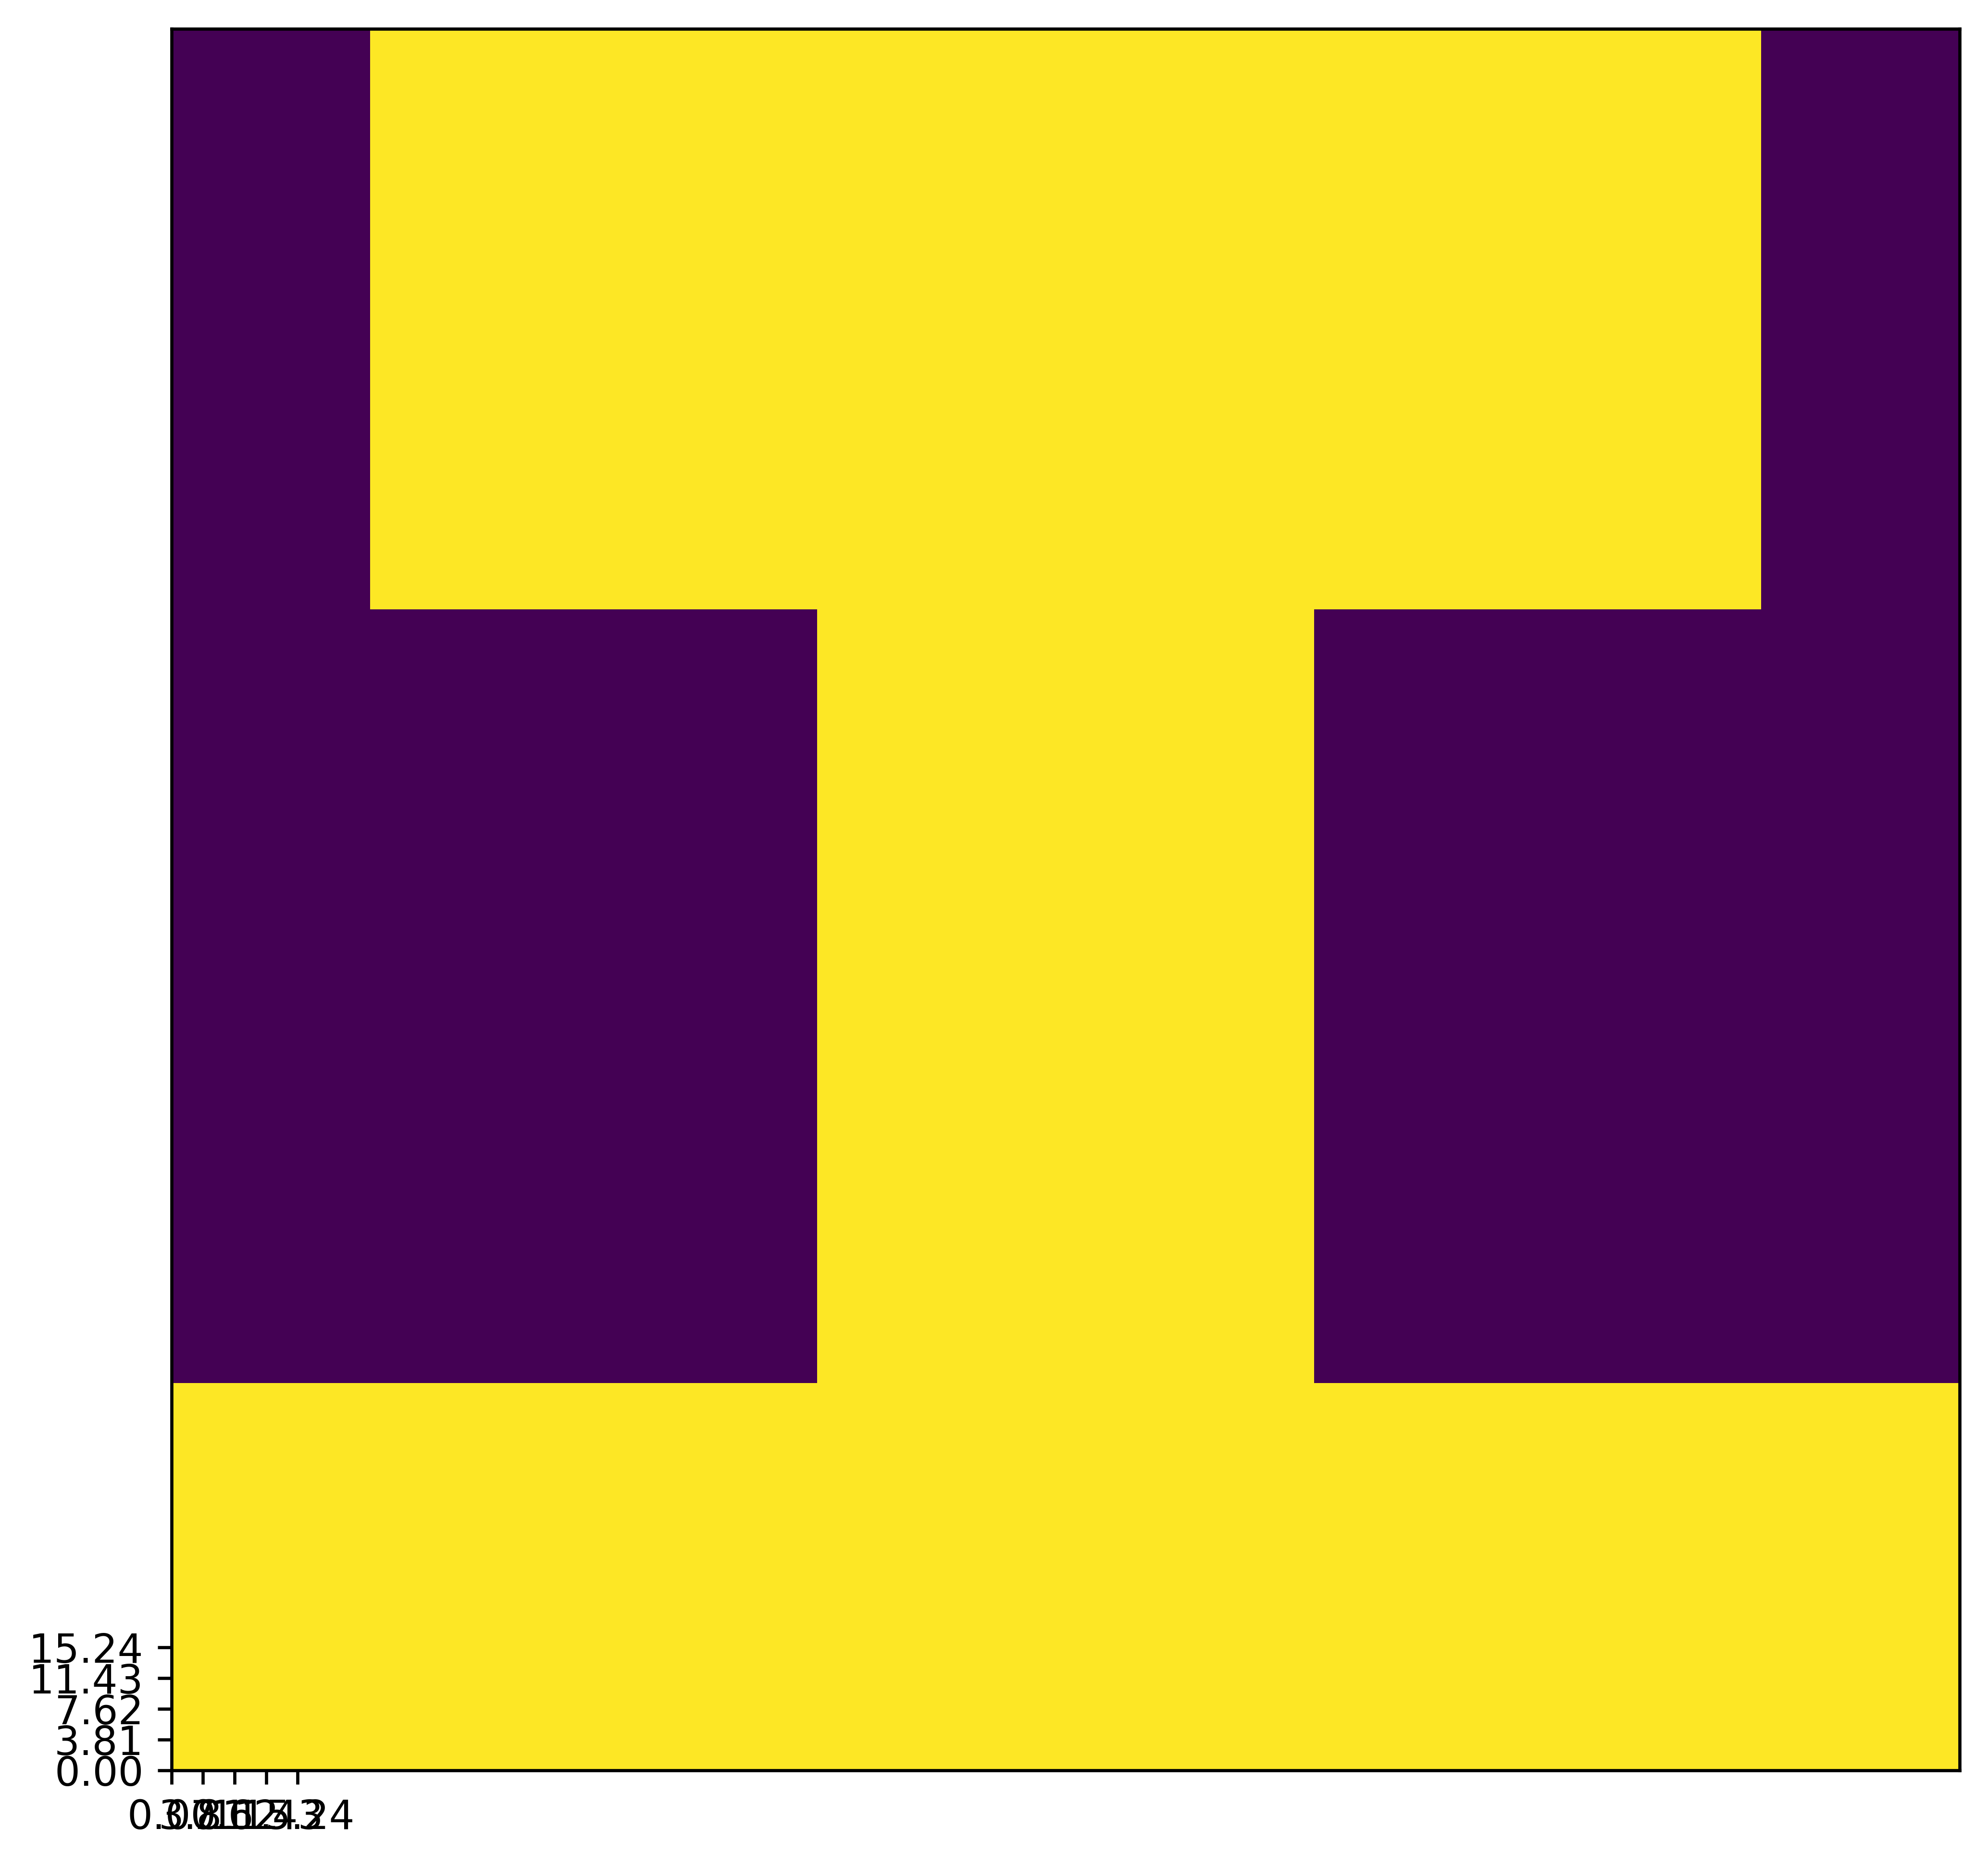

In [99]:
fig, ax = plt.subplots(figsize=(8,8), dpi = 600)
plt.pcolormesh(matPropsglob[0,1406,:,:].T)
ax.set_xticks(np.linspace(0,width1*100,5))
ax.set_yticks(np.linspace(0,height1*100,5))
plt.show()


In [82]:
#set the boundary conditions in material props4
Ties = 2

for yy in range(int(13/36*gw1)):
    y = yy + 0
    for zz in range(int(16/36*gh1)):
        z = zz + int(8/36*gh1)
        matPropsglob[3,:,y,z]=99

# zone 2 of air left of head
for yy in range(int(4/36*gw1)):
    y = yy + 0
    for zz in range(int(12/36*gh1)):
        z = zz + int(24/36*gh1)
        matPropsglob[3,:,y,z]=99

# zone 3 of air, right of web
for yy in range(int(13/36*gw1)):
    y = ymax - yy
    for zz in range(int(16/36*gh1)):
        z = zz + int(8/36*gh1)
        matPropsglob[3,:,y,z]=99

# zone 4 of air, right of head
for yy in range(int(4/36*gw1)):
    y = ymax - yy
    for zz in range(int(12/36*gh1)):
        z = zz + int(24/36*gh1)
        matPropsglob[3,:,y,z]=99

In [128]:
AirCut = True
if AirCut:
    #zone 1 of air, left of web
    for yy in range(int(13/36*gw1)):
        y = yy + 0
        for zz in range(int(16/36*gh1)):
            z = zz + int(8/36*gh1)
            matPropsglob[0,:,y,z]=rho2
            matPropsglob[1,:,y,z]=lmbda2
            matPropsglob[2,:,y,z]=mu2
            matPropsglob[3,:,y,z]=99
            
    # zone 2 of air left of head
    for yy in range(int(4/36*gw1)):
        y = yy + 0
        for zz in range(int(12/36*gh1)):
            z = zz + int(24/36*gh1)
            matPropsglob[0,:,y,z]=rho2
            matPropsglob[1,:,y,z]=lmbda2
            matPropsglob[2,:,y,z]=mu2
            matPropsglob[3,:,y,z]=99
            
    # zone 3 of air, right of web
    for yy in range(int(13/36*gw1)):
        y = ymax - yy
        for zz in range(int(16/36*gh1)):
            z = zz + int(8/36*gh1)
            matPropsglob[0,:,y,z]=rho2
            matPropsglob[1,:,y,z]=lmbda2
            matPropsglob[2,:,y,z]=mu2
            matPropsglob[3,:,y,z]=99
            
    # zone 4 of air, right of head
    for yy in range(int(4/36*gw1)):
        y = ymax - yy
        for zz in range(int(12/36*gh1)):
            z = zz + int(24/36*gh1)
            matPropsglob[0,:,y,z]=rho2
            matPropsglob[1,:,y,z]=lmbda2
            matPropsglob[2,:,y,z]=mu2
            matPropsglob[3,:,y,z]=99

#set the boundary conditions in material props4
Ties = 2

# top
matPropsglob[3,:,:,zmax]=2

# bottom 
matPropsglob[3,:,:,0]=1

# left
matPropsglob[3,:,0,:]=3

# right
matPropsglob[3,:,ymax,:]=4

# bottom right
matPropsglob[3,:,0,zmax]=13

# top rigight
matPropsglob[3,:,zmax,zmax]=14

#top of footing
z = int(8/36*gh1)
for yy in range(int(13/36*gw1)):
    y = yy + 0
    matPropsglob[3,:,y,z]=2
for yy in range(int(13/36*gw1)):
    y = yy + int(23/36*gw1)
    matPropsglob[3,:,y,z]=2

#sides of web
yl=int(13/36*gw1)
yr=int(23/36*gw1)
for zz in range(int(16/36*gh1)):
    z = zz + int(8/36*gh1)
    matPropsglob[3,:,yl,z]=3
    matPropsglob[3,:,yr,z]=4


#bottom of head
z=int(24/36*gh1)
for yy in range(int(8/36*gw1)):
    y=yy+int(5/36*gw1)
    matPropsglob[3,:,y,z]=1
    y=yy +int(23/36*gw1)
    matPropsglob[3,:,y,z]=1

#sides of head
yl=int(4/36*gw1)
yr=int(32/36*gw1)
for zz in range(int(12/36*gh1)):
    z = zmax - zz
    matPropsglob[3,:,yl,z]=3
    matPropsglob[3,:,yr,z]=4
    
#sides of foot
for zz in range(int(7/36*gh1)):
    z = zz
    matPropsglob[3,:,0,z]=3
    matPropsglob[3,:,ymax,z]=4


#top edge of foot on left
matPropsglob[3,:,0,int(8/36*gh1)]=13
#top endge of foot on right
matPropsglob[3,:,ymax,int(8/36*gh1)]=14

#bottom of head on left
matPropsglob[3,:,int(4/36*gw1),int(24/36*gh1)]=9
#bottom of head on right
matPropsglob[3,:,int(32/36*gw1),int(24/36*gh1)]=10

#Top of head on left
matPropsglob[3,:,int(4/36*gw1),zmax]=13
#top of head on right
matPropsglob[3,:,int(32/36*gw1),zmax]=14


if Ties ==2:  #tie on both end, absorbing all vertical velocity in square at end of track
    #face
    matPropsglob[3,0:gw1,:,0]=35
    matPropsglob[3,xmax-gw1:xmax,:,0]=35

    #Edges
    matPropsglob[3,0,:,0]=27
    matPropsglob[3,xmax,:,0]=28

    matPropsglob[3,0:gw1,0,0]=29
    matPropsglob[3,xmax-gw1:xmax,0,0]=29
    matPropsglob[3,0:gw1,ymax,0]=30
    matPropsglob[3,xmax-gw1:xmax,:,0]=30

    #corners
    matPropsglob[3,0,0,0] = 31
    matPropsglob[3,0,ymax,0]= 32
    matPropsglob[3,xmax,0,0]=33
    matPropsglob[3,xmax,ymax,0]=34

elif Ties == 1:  #tie in the middle
    half=int(gl1/2)
    halfwidth = int(gw1/2)
    start =half - halfwidth
    end = half+halfwidth

    #face
    matPropsglob[3,start:end,:,0]=35

    #edge
    matPropsglob[3,start:end,0,0]=29
    matPropsglob[3,start:end,ymax,0]=30

elif Ties == 3: #time on both end and in middle
    #end ties
    #face
    matPropsglob[3,0:gw1,:,0]=35
    matPropsglob[3,xmax-gw1:xmax,:,0]=35

    #Edges
    matPropsglob[3,0,:,0]=27
    matPropsglob[3,xmax,:,0]=28

    matPropsglob[3,0:gw1,0,0]=29
    matPropsglob[3,xmax-gw1:xmax,0,0]=29
    matPropsglob[3,0:gw1,ymax,0]=30
    matPropsglob[3,xmax-gw1:xmax,:,0]=30

    #corners
    matPropsglob[3,0,0,0] = 31
    matPropsglob[3,0,ymax,0]= 32
    matPropsglob[3,xmax,0,0]=33
    matPropsglob[3,xmax,ymax,0]=34   

    #middle Tie
    half=int(gl1/2)
    halfwidth = int(gw1/2)
    start =half - halfwidth
    end = half+halfwidth

    #face
    matPropsglob[3,start:end,:,0]=35

    #edge
    matPropsglob[3,start:end,0,0]=29
    matPropsglob[3,start:end,ymax,0]=30

In [127]:
matPropsglob[3,:,:,:]=0

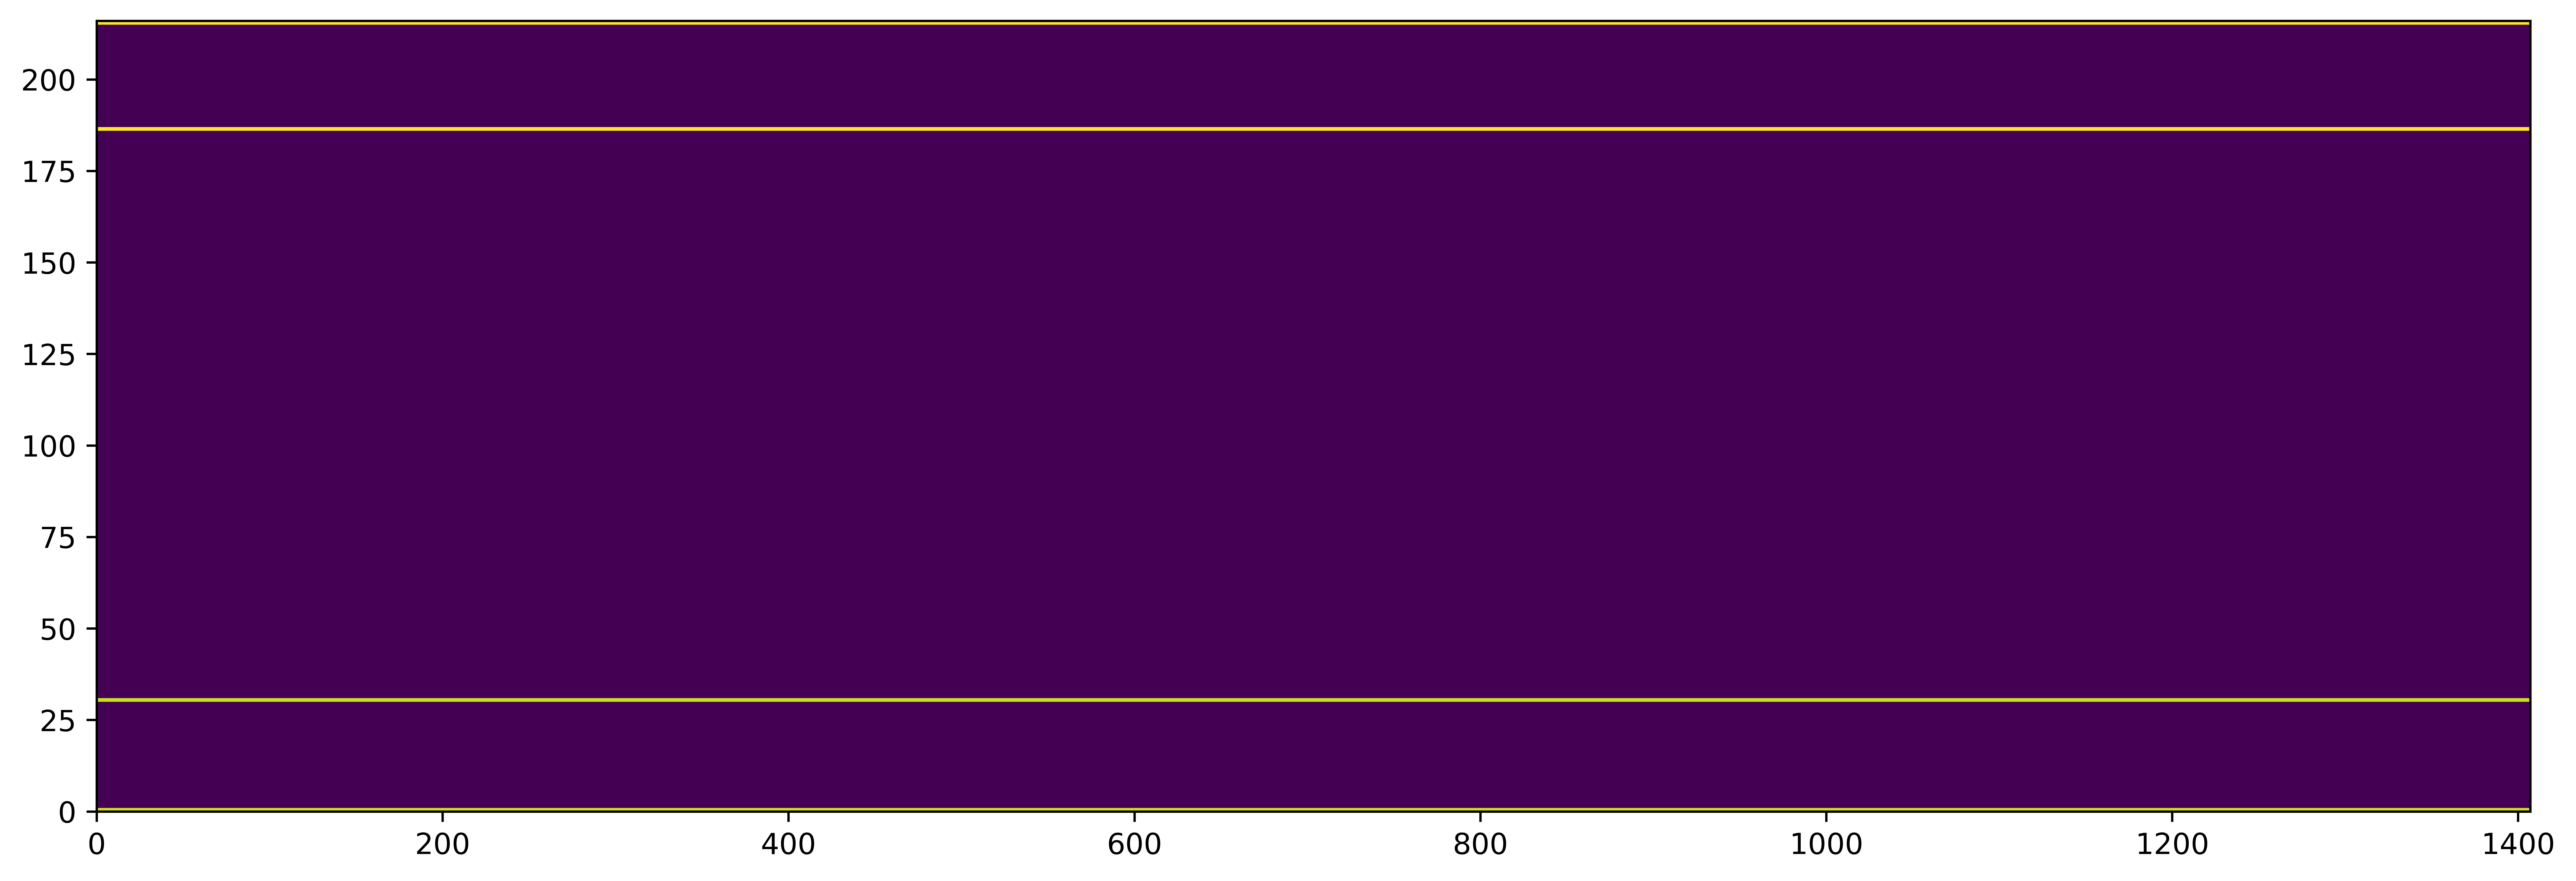

In [114]:
fig = plt.figure(figsize=(15,5), dpi=900)
plt.pcolormesh(matPropsglob[3,:,:,zmax].T)
plt.show()

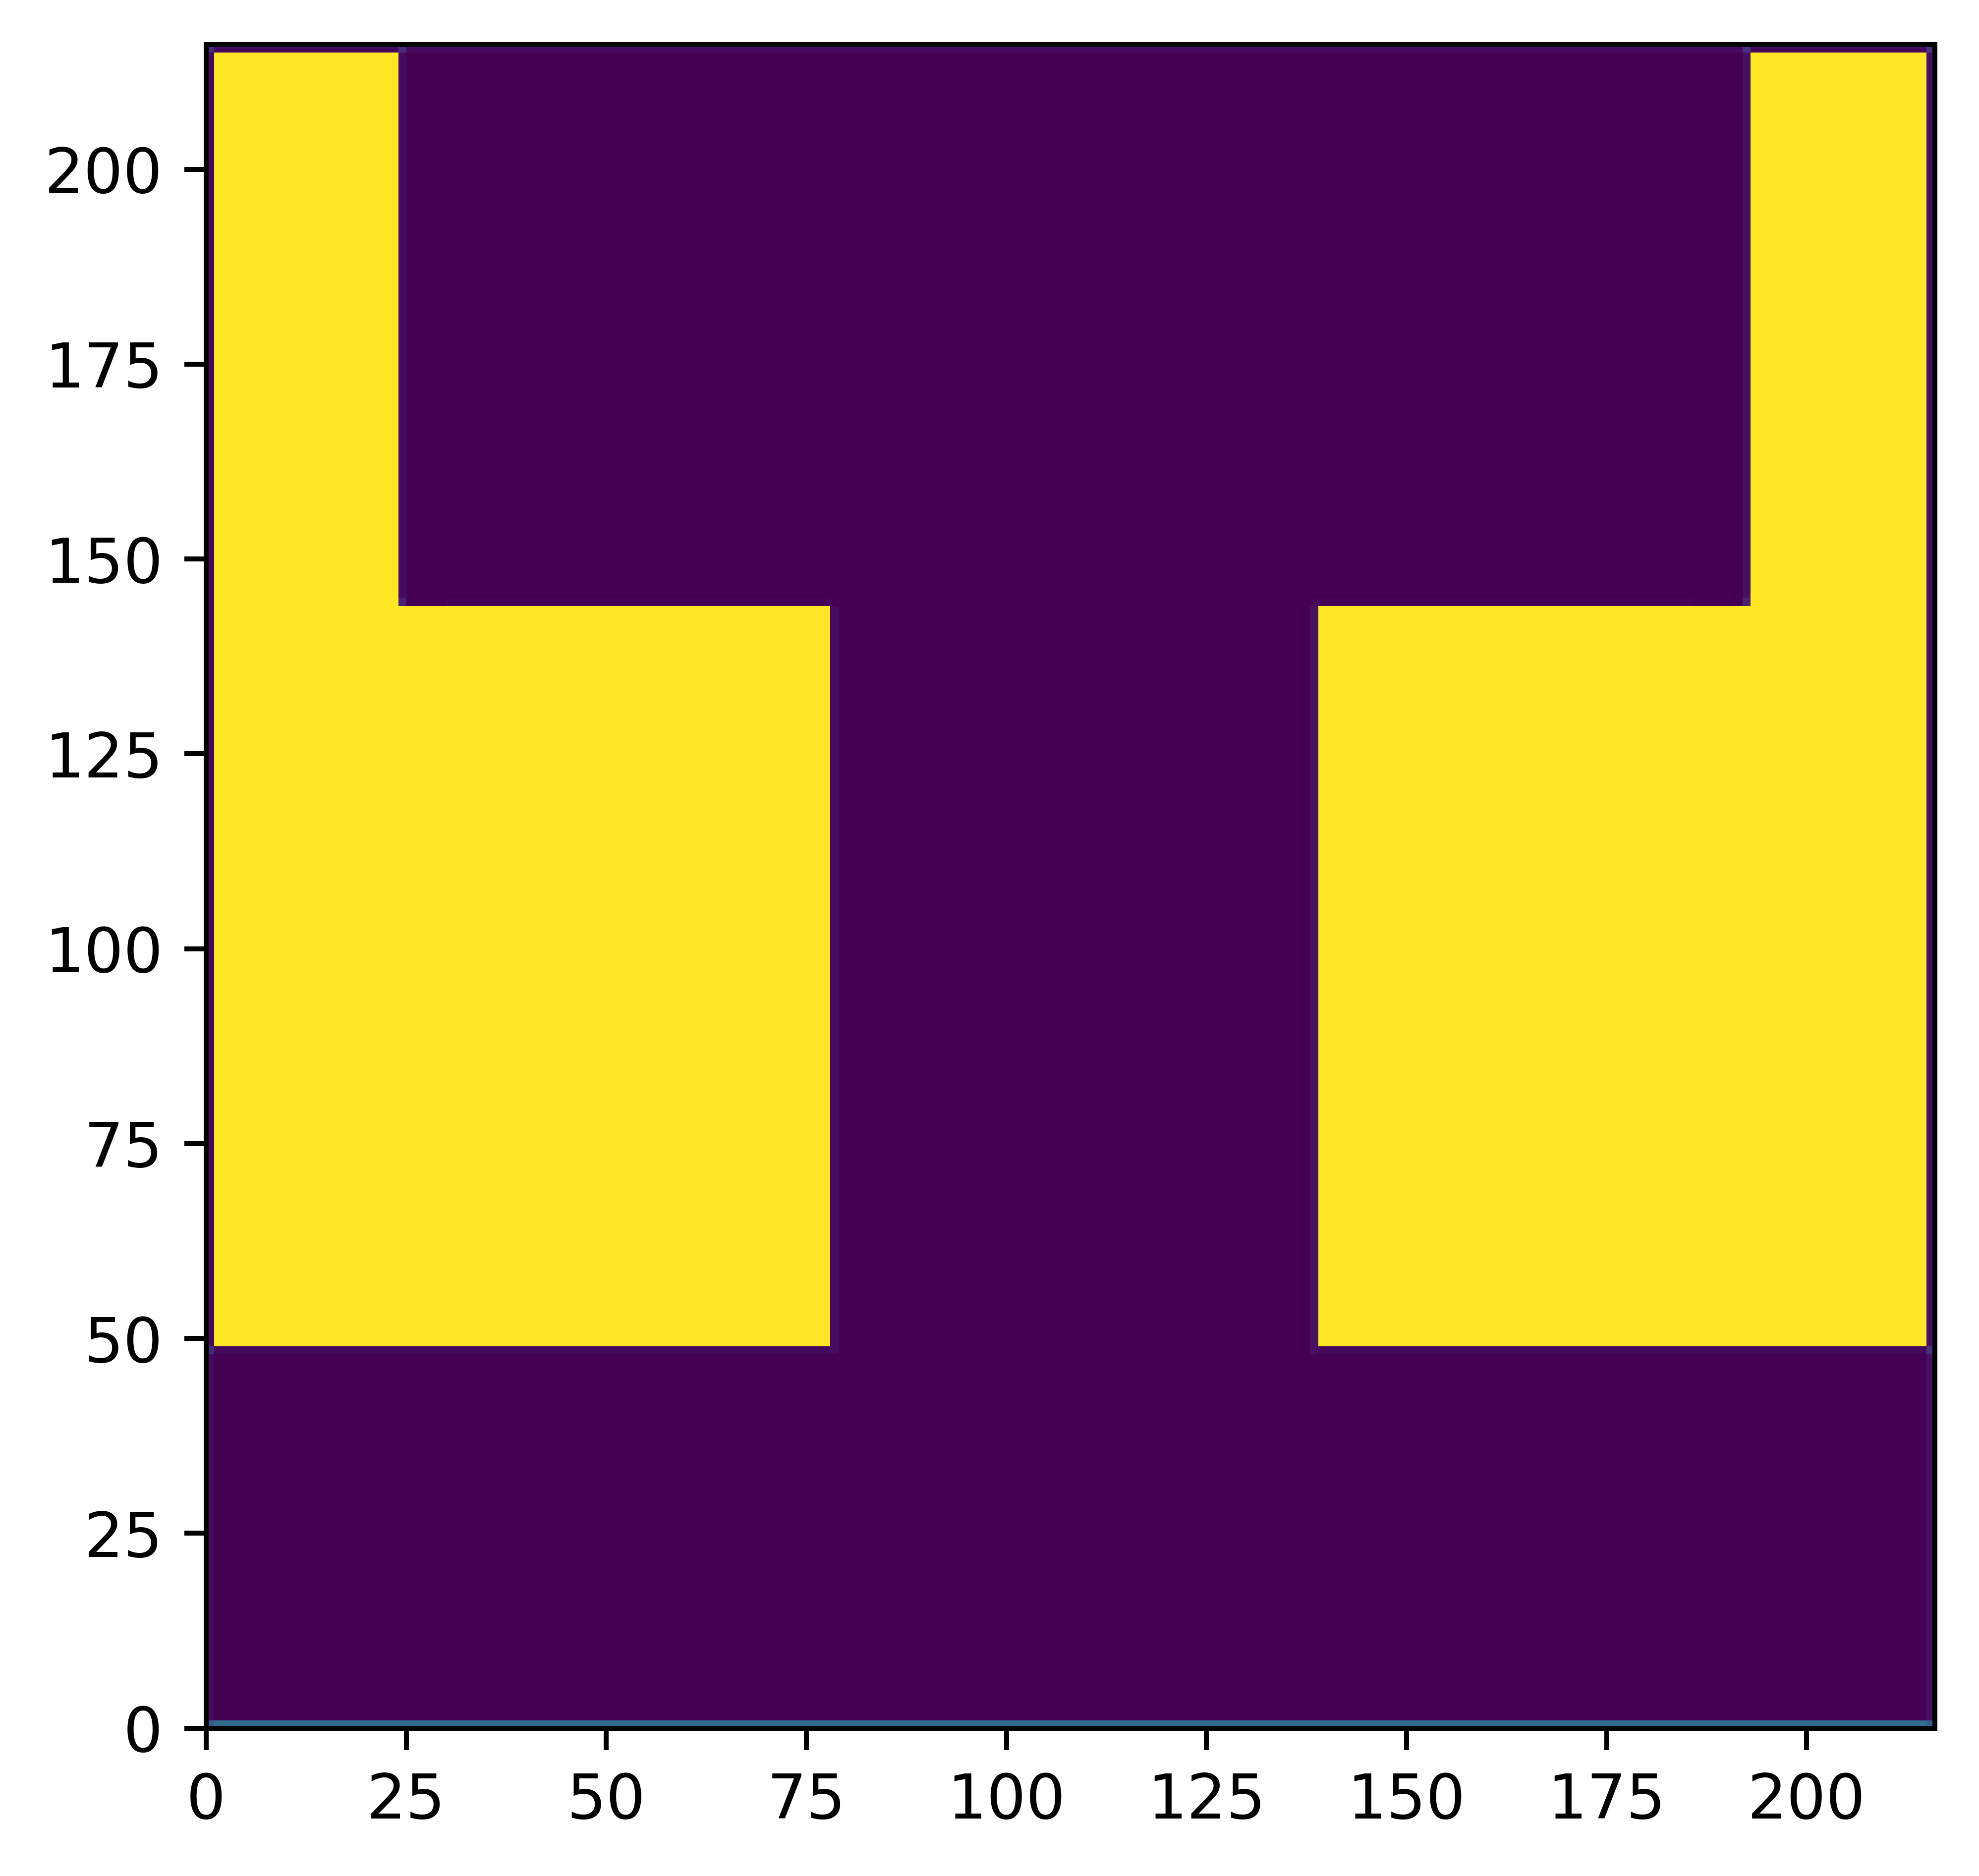

In [129]:
fig = plt.figure(figsize=(5,5), dpi=900)
plt.pcolormesh(matPropsglob[3,43,:,:].T)
plt.show()b

In [132]:
matPropsglob[3,43,210,0]

35.0

In [74]:
if Ties ==2:  #tie on both end, absorbing all vertical velocity in square at end of track
    #face
    matPropsglob[3,0:gw1,:,0]=35
    matPropsglob[3,xmax-gw1:xmax,:,0]=35

    #Edges
    matPropsglob[3,0,:,0]=27
    matPropsglob[3,xmax,:,0]=28

    matPropsglob[3,0:gw1,0,0]=29
    matPropsglob[3,xmax-gw1:xmax,0,0]=29
    matPropsglob[3,0:gw1,ymax,0]=30
    matPropsglob[3,xmax-gw1:xmax,:,0]=30

    #corners
    matPropsglob[3,0,0,0] = 31
    matPropsglob[3,0,ymax,0]= 32
    matPropsglob[3,xmax,0,0]=33
    matPropsglob[3,xmax,ymax,0]=34

elif Ties == 1:  #tie in the middle
    half=int(gl1/2)
    halfwidth = int(gw1/2)
    start =half - halfwidth
    end = half+halfwidth

    #face
    matPropsglob[3,start:end,:,0]=35

    #edge
    matPropsglob[3,start:end,0,0]=29
    matPropsglob[3,start:end,ymax,0]=30

elif Ties == 3: #time on both end and in middle
    #end ties
    #face
    matPropsglob[3,0:gw1,:,0]=35
    matPropsglob[3,xmax-gw1:xmax,:,0]=35

    #Edges
    matPropsglob[3,0,:,0]=27
    matPropsglob[3,xmax,:,0]=28

    matPropsglob[3,0:gw1,0,0]=29
    matPropsglob[3,xmax-gw1:xmax,0,0]=29
    matPropsglob[3,0:gw1,ymax,0]=30
    matPropsglob[3,xmax-gw1:xmax,:,0]=30

    #corners
    matPropsglob[3,0,0,0] = 31
    matPropsglob[3,0,ymax,0]= 32
    matPropsglob[3,xmax,0,0]=33
    matPropsglob[3,xmax,ymax,0]=34   

    #middle Tie
    half=int(gl1/2)
    halfwidth = int(gw1/2)
    start =half - halfwidth
    end = half+halfwidth

    #face
    matPropsglob[3,start:end,:,0]=35

    #edge
    matPropsglob[3,start:end,0,0]=29
    matPropsglob[3,start:end,ymax,0]=30

    
if myid == 0:
    print('air cuts made, line 355')

air cuts made, line 355


In [34]:
matPropsglob[3,1,:,:].T

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

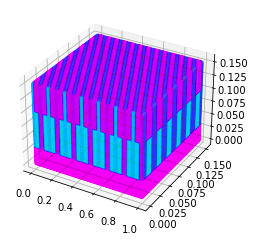

In [30]:
x=np.linspace(0,length1,gl1)
y=np.linspace(0,width1,gw1)
z=np.linspace(0,height1,gh1)

X, Y, Z = np.meshgrid(x, y, z)

U=matPropsglob[0,:,:,:]

if (myid == 0) :
    fig=plt.figure()    
    ax=plt.axes(projection='3d')    
    ax.scatter3D(X,Y,Z,c=U, alpha=0.02, marker='.', cmap='cool')    
    #plt.savefig('matprops.png')
    plt.show()
    plt.close(fig)    

In [ ]:
#define sine-exponential wave excitation

timeVec=np.linspace(0,runtime,Tsteps)

#MPI EJW Section #3 changes
#radius
r=3
inputx=2
inputy=int(gw1/2)
inputz=int(gh1/2)

# get loc by formula

inputid=int(inputx / npx)
inputlocx=int(inputx - inputid*npx+1)

In [ ]:
if (myid == 0) :
    print("line 369: glb inputx, local inputx id, local inputx:  ",inputx,inputid,inputlocx)


szzConst=2*ts/(gs*rho1)

amp=10000
decayRate= 0
sinConst=ts*amp/rho1

sinInputSignal=sinConst*np.sin(2*np.pi*frequency*timeVec)*np.exp(-decayRate*timeVec)

#readd plot once mapping function exists
if (myid == 0) :
    plt.plot(timeVec,sinInputSignal)
    plt.savefig('timevec.png')
    plt.close(fig)    

In [ ]:
# MPI EJW Section #4 changes 

#initialize fields
vx=np.zeros((npx+2,gw1,gh1))
vy=np.zeros((npx+2,gw1,gh1))
vz=np.zeros((npx+2,gw1,gh1))

sxx=np.zeros((npx+2,gw1,gh1))
syy=np.zeros((npx+2,gw1,gh1))
szz=np.zeros((npx+2,gw1,gh1))
sxy=np.zeros((npx+2,gw1,gh1))
sxz=np.zeros((npx+2,gw1,gh1))
syz=np.zeros((npx+2,gw1,gh1))

#record the signal at a specified location
### ADD map function for this
signalLocx=int(gl1/2)
signalLocy=int(gw1/2)
signalLocz=int(gh1/2)

#SAME AS INPUTZ?
signalLocxid=int(signalLocx / npx)
signalLocxlocx=int(signalLocx - myid*npx+1)

vxSignal=np.zeros(Tsteps)
vySignal=np.zeros(Tsteps)
vzSignal=np.zeros(Tsteps)

    